In [ ]:
!pip install opencv-python

In [ ]:
!pip install matplotlib

In [1]:
import os
import shutil
from sqlalchemy import create_engine, event, Table
from sqlalchemy.orm import sessionmaker

import shapely.wkb
import numpy as np
import cv2

from quickannotator.db import db, Project, Image, AnnotationClass, Notification, Tile, Setting, Annotation, SearchCache

In [2]:
db_path = "sqlite:////opt/QuickAnnotator/quickannotator/instance/quickannotator.db"
engine = create_engine(db_path)#,echo=True)

# Initialize Spatialite extension
@event.listens_for(engine, "connect")
def connect(dbapi_connection, connection_record):
    dbapi_connection.enable_load_extension(True)
    dbapi_connection.execute('SELECT load_extension("mod_spatialite")')
    dbapi_connection.execute('SELECT InitSpatialMetaData(1);')



In [3]:
models = [Image, AnnotationClass, Tile]
db.metadata.create_all(bind=engine, tables=[item.__table__ for item in models])

InitSpatiaMetaData() error:"table spatial_ref_sys already exists"


In [4]:
Session = sessionmaker(bind=engine)
session = Session()

In [6]:
# Get all annotation classes
annotation_classes = session.query(AnnotationClass).all()
print(annotation_classes)

[<AnnotationClass 1>, <AnnotationClass 2>, <AnnotationClass 3>]


In [7]:
class_id = 2

# Query all tiles for the current class
tiles = session.query(Tile).filter_by(annotation_class_id=class_id).all() ## filter by having a gt=True attribute
print(tiles)

[<Tile 1>, <Tile 2>, <Tile 3>, <Tile 4>, <Tile 5>, <Tile 6>, <Tile 7>, <Tile 8>, <Tile 9>, <Tile 10>, <Tile 11>, <Tile 12>, <Tile 13>, <Tile 14>, <Tile 15>, <Tile 16>, <Tile 17>, <Tile 18>, <Tile 19>, <Tile 20>, <Tile 21>, <Tile 22>, <Tile 23>, <Tile 24>, <Tile 25>, <Tile 26>, <Tile 27>, <Tile 28>, <Tile 29>, <Tile 30>, <Tile 31>, <Tile 32>, <Tile 33>, <Tile 34>, <Tile 35>, <Tile 36>, <Tile 37>, <Tile 38>, <Tile 39>, <Tile 40>, <Tile 41>, <Tile 42>, <Tile 43>, <Tile 44>, <Tile 45>, <Tile 46>, <Tile 47>, <Tile 48>, <Tile 49>, <Tile 50>, <Tile 51>, <Tile 52>, <Tile 53>, <Tile 54>, <Tile 55>, <Tile 56>, <Tile 57>, <Tile 58>, <Tile 59>, <Tile 60>, <Tile 61>, <Tile 62>, <Tile 63>, <Tile 64>, <Tile 65>, <Tile 66>, <Tile 67>, <Tile 68>, <Tile 69>, <Tile 70>, <Tile 71>, <Tile 72>, <Tile 73>, <Tile 74>, <Tile 75>, <Tile 76>, <Tile 77>, <Tile 78>, <Tile 79>, <Tile 80>, <Tile 81>, <Tile 82>, <Tile 83>, <Tile 84>, <Tile 85>, <Tile 86>, <Tile 87>, <Tile 88>, <Tile 89>, <Tile 90>, <Tile 91>, <Tile 9

In [52]:
import openslide
from sqlalchemy import inspect

for tile in tiles:
    image_id = tile.image_id
    gtpred = 'gt'  # or 'pred' based on your requirement
    table_name = f"{image_id}_{class_id}_{gtpred}_annotation"

    # Check if the table exists
    inspector = inspect(engine)
    if not inspector.has_table(table_name):
        continue

    table = Table(table_name, db.metadata, autoload_with=engine)

    annotations = session.query(table).filter(
        table.c.polygon.ST_Within(tile.geom)
    ).all()
    
    
    if len(annotations) == 0:
        continue

    print("non zero", len(annotations))
    tpoly=shapely.wkb.loads(tile.geom.data)

    # Get the bounds of the polygon
    minx, miny, maxx, maxy = tpoly.bounds

    # Compute the width and height
    width = int(maxx - minx)
    height = int(maxy - miny)


    #--- image work
    image = session.query(Image).filter_by(id=image_id).first()
    if not image:
        continue

    image_path = image.path
    print(image_path)
    slide = openslide.OpenSlide("../"+image_path)

    # Extract the region defined by the tile
    region = slide.read_region((int(minx), int(miny)), 0, (width, height))

    io_filename = f"io_{tile.id}.png"
    region.save(io_filename)

    print(f"Width: {width}, Height: {height}")

    mask = np.zeros((height, width), dtype=np.uint8)

    for annotation in annotations:
        annotation_polygon = shapely.wkb.loads(annotation.polygon.data)
       
        # Translate the annotation polygon to the tile's coordinate system
        translated_polygon = shapely.affinity.translate(annotation_polygon, xoff=-minx, yoff=-miny)
        
        # Draw the translated polygon on the mask
        cv2.fillPoly(mask, [np.array(translated_polygon.exterior.coords, dtype=np.int32)], 1)
    
    
    mask_filename = f"mask_{tile.id}.png"
    cv2.imwrite(mask_filename, mask)





non zero 1
data/test_ndpi/13_266069_040_003 L02 PAS.ndpi
Width: 2048, Height: 2048
non zero 4
data/test_ndpi/13_266069_040_003 L02 PAS.ndpi
Width: 2048, Height: 2048
non zero 21
data/test_ndpi/13_266069_040_003 L02 PAS.ndpi
Width: 2048, Height: 2048
non zero 13
data/test_ndpi/13_266069_040_003 L02 PAS.ndpi
Width: 2048, Height: 2048
non zero 10
data/test_ndpi/13_266069_040_003 L02 PAS.ndpi


KeyboardInterrupt: 

In [60]:
session.rollback()

In [ ]:
session.close()

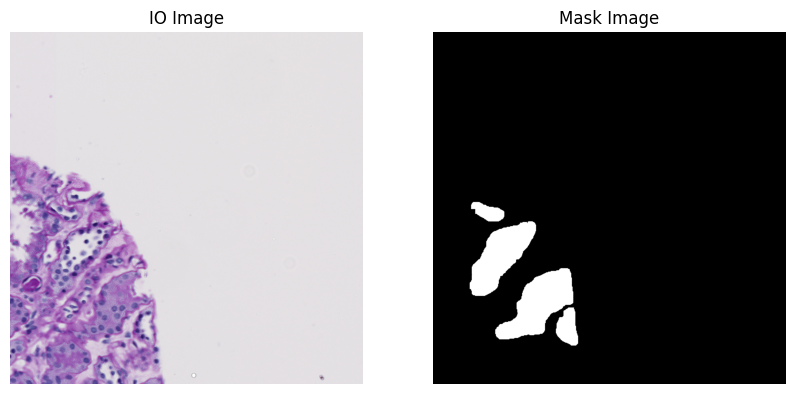

In [59]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

num=324
# Load images
io_image = mpimg.imread(f'io_{num}.png')
mask_image = mpimg.imread(f'mask_{num}.png')

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display the images
axes[0].imshow(io_image)
axes[0].set_title('IO Image')
axes[0].axis('off')

axes[1].imshow(mask_image, cmap='gray')
axes[1].set_title('Mask Image')
axes[1].axis('off')

plt.show()

In [ ]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [75]:
import openslide
from torch.utils.data import Dataset, DataLoader, IterableDataset
import numpy as np
from PIL import Image as PILImage

In [79]:

import torchvision.transforms as transforms

class TileDataset(IterableDataset):
    def __init__(self, tiles, transform=None):
        self.tiles = tiles
        self.transform = transform

    def __iter__(self):
        for tile in self.tiles:
            image_id = tile.image_id
            gtpred = 'gt'  # or 'pred' based on your requirement
            table_name = f"{image_id}_{class_id}_{gtpred}_annotation"

            # Check if the table exists
            inspector = inspect(engine)
            if not inspector.has_table(table_name):
                continue

            table = Table(table_name, db.metadata, autoload_with=engine)

            annotations = session.query(table).filter(
                table.c.polygon.ST_Within(tile.geom)
            ).all()

            if len(annotations) == 0:
                continue

            tpoly = shapely.wkb.loads(tile.geom.data)

            # Get the bounds of the polygon
            minx, miny, maxx, maxy = tpoly.bounds

            # Compute the width and height
            width = int(maxx - minx)
            height = int(maxy - miny)

            #--- image work
            image = session.query(Image).filter_by(id=image_id).first()
            if not image:
                continue

            image_path = image.path
            slide = openslide.OpenSlide("../" + image_path)

            # Extract the region defined by the tile
            region = slide.read_region((int(minx), int(miny)), 0, (width, height))
            io_image = region.convert("RGB")

            mask_image = np.zeros((height, width), dtype=np.uint8)

            for annotation in annotations:
                annotation_polygon = shapely.wkb.loads(annotation.polygon.data)
                translated_polygon = shapely.affinity.translate(annotation_polygon, xoff=-minx, yoff=-miny)
                cv2.fillPoly(mask_image, [np.array(translated_polygon.exterior.coords, dtype=np.int32)], 1)

            # Convert PIL images to tensors
            io_image = transforms.ToTensor()(io_image)
            mask_image = transforms.ToTensor()(mask_image)

            if self.transform:
                io_image = self.transform(io_image)
                mask_image = self.transform(mask_image)

            yield io_image, mask_image

# Example usage
transform = None  # Define any transformations if needed
dataset = TileDataset(tiles, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=False)

# Iterate through the dataloader
for images, masks in dataloader:
    print(images.shape, masks.shape)
    break


torch.Size([4, 3, 2048, 2048]) torch.Size([4, 1, 2048, 2048])


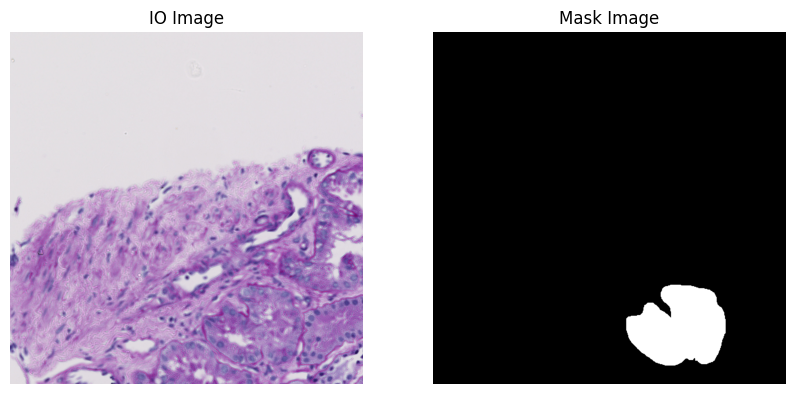

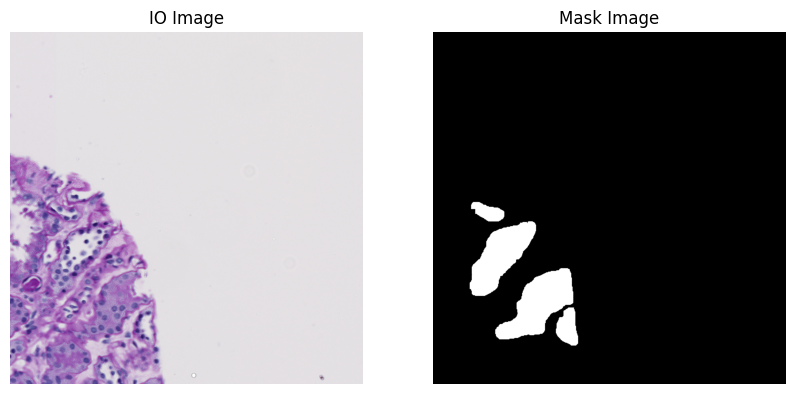

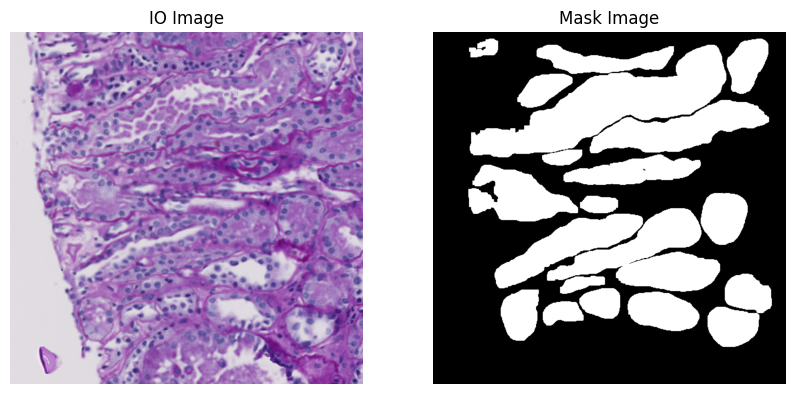

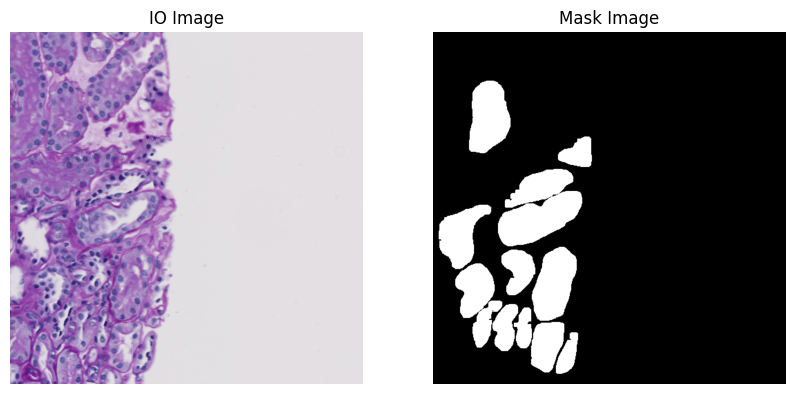

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Iterate through the batch of images and masks
for i in range(images.shape[0]):
    io_image = images[i].permute(1, 2, 0).numpy()  # Shift the channel to the end
    mask_image = masks[i].squeeze().numpy()  # Remove the channel dimension for mask

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Display the images
    axes[0].imshow(io_image)
    axes[0].set_title('IO Image')
    axes[0].axis('off')

    axes[1].imshow(mask_image, cmap='gray')
    axes[1].set_title('Mask Image')
    axes[1].axis('off')

    plt.show()

